In [11]:
import random
import numpy as np
import math

import torch
import torch.utils.data as data_utils

import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from multiclassifier import Model

seedy = 666
random.seed(seedy)

### Load motif data.

In [12]:
train_motifs = np.genfromtxt('data/train_motifs.csv',dtype='U')
train_motifxFamMatrix = np.genfromtxt('data/train_motifxFamMatrix.csv',delimiter=',',dtype=int)
test_motifs = np.genfromtxt('data/new_test_motifs.csv',dtype='U')
test_motifxFamMatrix = np.genfromtxt('data/new_test_motifxFamMatrix.csv',delimiter=',',dtype=int)
fams = np.genfromtxt('data/fams.csv',dtype='U')

## Split data into folds in a stratified k-fold manner.

def proba_mass_split(y, folds=5):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in range(folds):
        index_list.append([])
    for i in range(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
    return index_list

np.random.seed(seedy)
folds = proba_mass_split(train_motifxFamMatrix)

### Load embedding coordinates and kinase family distances.

In [13]:
#############################################
# Get Siamese embedding coords.
#############################################

embedding = np.genfromtxt('MODELS_siam/embedding.csv',delimiter=',',dtype=float)
train_embedding = embedding[ :len(train_motifs) ]
test_embedding = embedding[ len(train_motifs): ]
print(embedding.shape)

#############################################
# Get fam distance matrix for Phylo MSE loss.
#############################################

all_fams = (np.genfromtxt('data/fam_distances_blos62/fams.csv',dtype='U'))
dist_matrix = (np.genfromtxt('data/fam_distances_blos62/dist_matrix.csv',delimiter=',',dtype=float))

fam_idc = [np.where(all_fams==fam)[0][0] for fam in fams]
fam_dist_matrix = dist_matrix[fam_idc][:,fam_idc]
        
# normalize fam distances
fMax = np.max(fam_dist_matrix)
fMin = np.min(fam_dist_matrix)

fam_dist_matrix_scaled = np.array((fam_dist_matrix))
for i in range(len(fams)):
    for j in range(len(fams)):
        fam_dist_matrix_scaled[i][j] = 1 - float(fam_dist_matrix[i][j]-fMin)/(fMax-fMin) 
fam_dist_matrix = fam_dist_matrix_scaled

famDistMatrix = fam_dist_matrix

(7302, 100)


### Misc functions for data pre-processing.

In [14]:
AMINOS = 'XWGSAELQDMPFTRIHVNCY_K'

def get_oneHot_motifs(motifs, AMINOS=AMINOS):
    oneHot_motifs = []
    for motif in motifs:
        one_hotted = np.zeros((len(motif), len(AMINOS)),dtype=float)
        for i,aa in enumerate(motif):
            hot = AMINOS.find(aa)
            one_hotted[i][hot] = 1
        oneHot_motifs.append(one_hotted)
    oneHot_motifs = np.asarray(oneHot_motifs)
    oneHot_motifs = np.swapaxes(oneHot_motifs,1,2)
    return oneHot_motifs

def get_stacked_features(motifs, embeddings):
    oneHot_motifs = get_oneHot_motifs(motifs)
    squished_oneHots = oneHot_motifs.reshape(oneHot_motifs.shape[0],oneHot_motifs.shape[1]*
                                         oneHot_motifs.shape[2])
    stacked_features = np.hstack((squished_oneHots,embeddings))
    stacked_features = torch.tensor(stacked_features)
    return stacked_features        

def get_loader(motifs,embedding,motifxFamMatrix,idc,my_batch):
    these_motifs = motifs[idc]
    this_embedding = embedding[idc]
    X = get_stacked_features(these_motifs,this_embedding)
    Y = torch.tensor(motifxFamMatrix[idc])
    dataset = data_utils.TensorDataset(X, Y)
    loader = data_utils.DataLoader(dataset, batch_size=my_batch, shuffle=True, drop_last=True)
    return loader

In [15]:
def eval_model(model, thresh=0.5):
    
    model.eval()
    loader = get_loader(test_motifs,test_embedding,test_motifxFamMatrix,range(len(test_motifs)),len(test_motifs))
    
    for inputs, labels in loader:
        
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)

        motif = inputs[:,:-embedding.shape[1]].reshape( len(test_motifs), len(AMINOS), len(train_motifs[0]) )
        coords = inputs[:,-embedding.shape[1]:]
        
        outputs = model.forward(motif, coords)
        
        accuracy = 0
        totTrues = 0
        for i,out in enumerate(outputs):
            pred = np.where(out.cpu().detach().numpy() > thresh)[0]
            true = np.where(labels.data.cpu()[i]==1)[0]
            totTrues += len(true)
            accuracy += len(pred)

        y_score = outputs.cpu().detach().numpy()
        y_test = np.asarray(labels.cpu())
                
        return y_test, y_score

In [16]:
run = open("./run.cfg", "r").read()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

all_y_scores = []
all_y_test = []
for i in range(5):
    
    model = Model()
    model = model.to(device)
    model.load_state_dict(torch.load("MODELS_multiclass/%s/%d_weights" % (run,i)))
    
    y_test, y_score = eval_model(model)
    all_y_scores.extend(y_score)
    all_y_test.extend(y_test)
    
y_score = np.asarray(all_y_scores)
y_test = np.asarray(all_y_test)

In [17]:
## ROC



FAM_IDC = [x for x in range(len(fams))]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in FAM_IDC:
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in FAM_IDC]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in FAM_IDC:
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(FAM_IDC)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

In [18]:
## PRECISION-RECALL



precision = dict()
recall = dict()
average_precision = dict()

for i in range(len(fams)):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), y_score.ravel())

average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")
average_precision["macro"] = average_precision_score(y_test, y_score, average="macro")

In [19]:
fam_to_col = {'AKT': 'red',
              'CDK': 'magenta',
              'CK2': 'orange',
              'MAPK': 'gold',
              'PIKK': 'yellowgreen',
              'PKA': 'turquoise',
              'PKC': 'blue',
              'SRC': 'purple'}

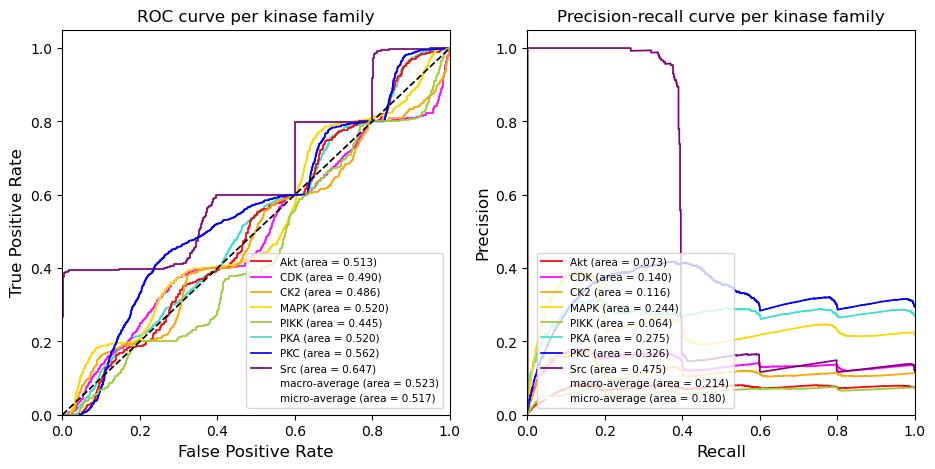

In [21]:
# from itertools import cycle

plt.style.use('default')
# fig, (ax1, ax2) = plt.subplots(2,figsize=(5,11))
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(11,5))

lw = 1.25

############################################################
###################  AUROC #################################
############################################################

lines = []
labels = []

l, = ax1.plot(0,0,color='white')
lines.append(l)
labels.append('micro-average (area = {0:0.3f})'.format(roc_auc["micro"]))
l, = ax1.plot(0,0,color='white')
lines.append(l)
labels.append('macro-average (area = {0:0.3f})'.format(roc_auc["macro"]))

for i,fam in enumerate(fams):
    fclass = fams[i]
    if fclass=='AKT':
        fclass = 'Akt'
    if fclass=='SRC':
        fclass = 'Src'    
    l, = ax1.plot(fpr[i], tpr[i], color=fam_to_col[fam], lw=lw,
             label='{0} (area = {1:0.3f})'.format(fclass, roc_auc[i]))
    labels.append('{0} (area = {1:0.3f})'.format(fclass, roc_auc[i]))
    lines.append(l)

fig.subplots_adjust(hspace=.275)
ax1.plot([0, 1], [0, 1], 'k--', lw=lw)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.tick_params(axis="x", labelsize=10)
ax1.tick_params(axis="y", labelsize=10)
ax1.set_xlabel('False Positive Rate',fontsize=12)
ax1.set_ylabel('True Positive Rate',fontsize=12) 
ax1.set_title('ROC curve per kinase family',fontsize=12) 
labels, lines = zip(*sorted(zip(labels, lines), key=lambda t: t[0], reverse=False))
ax1.legend(lines, labels, loc=(0.475, .0175), fontsize=7.5)  # (1.05, .0)

############################################################
###############  PRECISION-RECALL ##########################
############################################################

lines = []
labels = []

l, = ax2.plot(0,0,color='white')
lines.append(l)
labels.append('micro-average (area = {0:0.3f})'.format(average_precision["micro"]))
l, = ax2.plot(0,0,color='white')
lines.append(l)
labels.append('macro-average (area = {0:0.3f})'.format(average_precision["macro"]))

for i,fam in enumerate(fams):
    l, = ax2.plot(recall[i], precision[i], color=fam_to_col[fam], lw=lw)
    lines.append(l)
    fclass = fams[i]
    if fclass=='AKT':
        fclass = 'Akt'
    if fclass=='SRC':
        fclass = 'Src'
    labels.append('{0} (area = {1:0.3f})'.format(fclass, average_precision[i]))

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.tick_params(axis="x", labelsize=10)
ax2.tick_params(axis="y", labelsize=10)
ax2.set_xlabel('Recall',fontsize=12) 
ax2.set_ylabel('Precision',fontsize=12) 
ax2.set_title('Precision-recall curve per kinase family',fontsize=12) 

labels, lines = zip(*sorted(zip(labels, lines), key=lambda t: t[0], reverse=False))
ax2.legend(lines, labels, loc=(0.025, .0175), fontsize=7.5) # (1.05, .0)

plt.savefig("FIGS_multiclass/%s_roc-prc.png" % run, bbox_inches='tight')
plt.show()

In [ ]:
confusion = np.zeros((len(fams), len(fams)),dtype=float)

for i,score in enumerate(y_score):
    pred = np.where(score > 0.5000)[0]
    if len(pred)<1:
        pred = [np.argmax(score)]
    true = np.where(y_test[i]==1)[0]
    for p_idx in pred:
        for t_idx in true:
            confusion[p_idx][t_idx] += 1
            
labs = confusion.copy()

for i in range(len(fams)):
    confusion[i] = confusion[i] / confusion[i].sum()
for i in range(len(fams)):
    for j in range(len(fams)):
        if math.isnan(confusion[i][j]) or confusion[i][j]==0:
            confusion[i][j]=0

In [ ]:
heat_map = sb.heatmap(confusion, annot=labs, cmap="GnBu_r", fmt='1.0f',
                      square=False, yticklabels=fams, xticklabels=fams )

b, t = plt.ylim() 
plt.ylim(b, t) 

plt.xlabel("True label",fontsize=12, labelpad=10)
plt.ylabel("Predicted label",fontsize=12, labelpad=10)
plt.title("Confusion matrix for kinase labels",fontsize=12, pad=12)
plt.savefig("FIGS_multiclass/%s_confusion" % run, bbox_inches='tight')

plt.show()